<a href="https://colab.research.google.com/github/hmahadik/deep-person-reid/blob/master/Pytorch_Reid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies
Install torch, torchvision, and pytorch-reid

In [0]:
%%bash
cd /content
pip3 install torch torchvision onnx
if [ -e deep-person-reid ]
then
    echo "Looks like deep-person-reid is already cloned"
else
    git clone https://github.com/KaiyangZhou/deep-person-reid.git
fi
cd deep-person-reid/
pip3 install -r requirements.txt
python3 setup.py install

Looks like deep-person-reid is already cloned
running install
running bdist_egg
running egg_info
writing torchreid.egg-info/PKG-INFO
writing dependency_links to torchreid.egg-info/dependency_links.txt
writing requirements to torchreid.egg-info/requires.txt
writing top-level names to torchreid.egg-info/top_level.txt
writing manifest file 'torchreid.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/torchreid
copying build/lib.linux-x86_64-3.6/torchreid/__init__.py -> build/bdist.linux-x86_64/egg/torchreid
creating build/bdist.linux-x86_64/egg/torchreid/utils
copying build/lib.linux-x86_64-3.6/torchreid/utils/tools.py -> build/bdist.linux-x86_64/egg/torchreid/utils
copying build/lib.linux-x86_64-3.6/torchreid/utils/reidtools.py -> build/bdist.linux-x86_64/egg/torchreid/utils
copying build/lib.linux-x86_64-3.6/torchreid/utils/__init_

/content/deep-person-reid/torchreid/metrics/rank.py:17: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  'Cython evaluation (very fast so highly recommended) is '
zip_safe flag not set; analyzing archive contents...
torchreid.metrics.rank_cylib.__pycache__.rank_cy.cpython-36: module references __file__
torchreid.metrics.rank_cylib.__pycache__.test_cython.cpython-36: module references __file__


### Mount Google Drive (optional)

Useful for uploading and saving models, images, and other files.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup model

Load a pre-trained model (osnet_ibn_x1_0) downloaded from pytorch reid's model zoo (https://kaiyangzhou.github.io/deep-person-reid/MODEL_ZOO).

To visualize model, go to https://lutzroeder.github.io/netron/


In [0]:
import sys
import os
import os.path as osp
import warnings
import time

import torch
import torch.nn as nn

os.chdir("/content/deep-person-reid")
from scripts.default_parser import (
    init_parser, imagedata_kwargs, videodata_kwargs,
    optimizer_kwargs, lr_scheduler_kwargs, engine_run_kwargs
)
import torchreid
from torchreid.utils import (
    Logger, set_random_seed, check_isfile, resume_from_checkpoint,
    load_pretrained_weights, compute_model_complexity, collect_env_info
)

torch.backends.cudnn.benchmark = True

print("Preparing data manager")
datamanager = torchreid.data.ImageDataManager(
    root='reid-data',
    sources="market1501", # ['market1501', 'dukemtmcreid', 'cuhk03', 'msmt17']
    height=256,
    width=128,
    batch_size=64
)


arch = "osnet_ibn_x1_0" # torchreid.models.show_avai_models()
print("datamanager.num_train_pids = {}".format(datamanager.num_train_pids))
print('Building model: {}'.format(arch))
model = torchreid.models.build_model(
    name=arch,
    num_classes=datamanager.num_train_pids,
    loss="argmax", # choices=['softmax', 'triplet'],
    pretrained=True,
    use_gpu=True
)
num_params, flops = compute_model_complexity(model, (1, 3, 256, 128))
print('Model complexity: params={:,} flops={:,}'.format(num_params, flops))
weights = "/content/drive/My Drive/Colab Notebooks/reid-models/osnet_ibn_x1_0_market1501_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip_jitter.pth"
load_pretrained_weights(model, weights)
model.eval()
print(model.state_dict)

dummy_input = torch.randn(1, 3, 256, 128)
print("\nExporting model to .onnx format...")
torch.onnx.export(model, 
                  dummy_input, 
                  "osnet_ibn_x1_0.onnx",     # output filename
                  export_params=True,        # export weights 
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                 )

print("Model saved as osnet_ibn_x1_0.onnx")
!echo "" && pwd && ls -lh ./

model = nn.DataParallel(model).cuda()

print("\nDoing a foward pass on the model to get feature vector")
time_start = time.time()
model_output = model(dummy_input)
time_end = time.time()
print("forward pass took {} seconds".format(time_end-time_start))
print("output (feature vector of size {}): {}".format(len(model_output[0]), model_output[0]))

optimizer = torchreid.optim.build_optimizer(model)
scheduler = torchreid.optim.build_lr_scheduler(optimizer, lr_scheduler="multi_step", stepsize=[10,20])

Preparing data manager
Building train transforms ...
+ resize to 256x128
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |   

# Train

In [0]:
#TODO

# Evaluate

### Using the torchreid API

In [0]:
engine = torchreid.engine.ImageSoftmaxEngine(
            datamanager,
            model,
            optimizer,
            scheduler=scheduler,
            use_cpu=False,
            label_smooth=True
        )
engine.run(test_only=True)

##### Evaluating market1501 (source) #####
Extracting features from query set ...
Done, obtained 3368-by-512 matrix
Extracting features from gallery set ...
Done, obtained 15913-by-512 matrix
Speed: 0.0349 sec/batch
Computing distance matrix with metric=euclidean ...
Computing CMC and mAP ...
** Results **
mAP: 78.7%
CMC curve
Rank-1  : 92.5%
Rank-5  : 97.0%
Rank-10 : 98.1%
Rank-20 : 99.0%


# Display results
Showing one randomly chosen result. Leftmost image is the query image followed by the top-k results where a green bounding box equals correct reidentification.

In [0]:
from google.colab.patches import cv2_imshow
import cv2
import os

def show_images(filepaths):
    for filepath in filepaths:
        print(os.path.basename(filepath))
        img = cv2.imread(filepath)
        cv2_imshow(img)
        print("\n")


1306_c3s3_032603_00.jpg


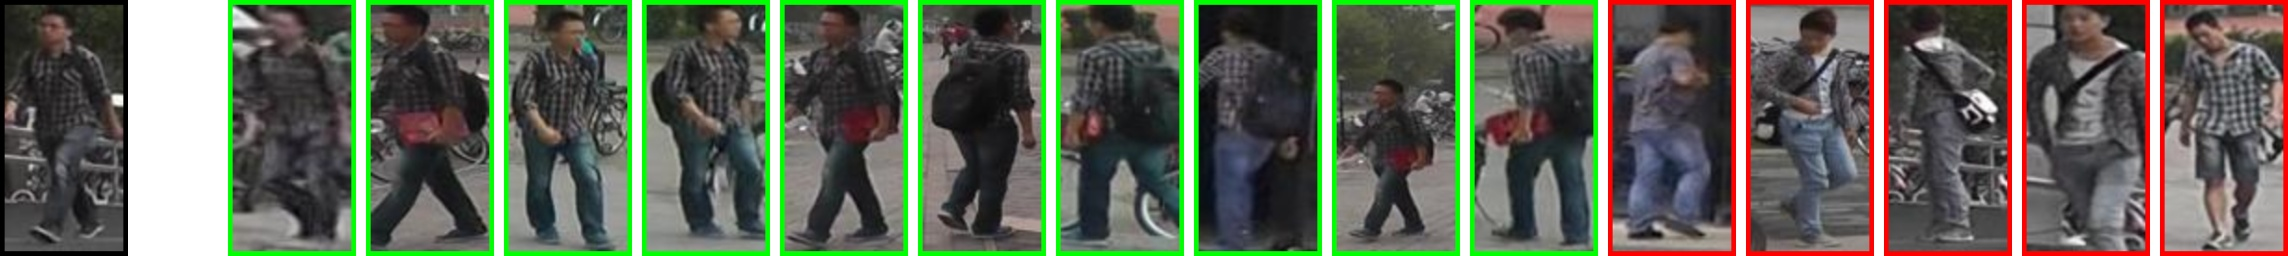

In [0]:
directory_of_images = "/content/drive/My Drive/Colab Notebooks/log/eval-osnet_ibn_x1_0_market1501_256x128_amsgrad_ep150_stp60_lr0.0015_b64_fb10_softmax_labelsmooth_flip_jitter/visrank_market1501"
filenames_of_images = os.listdir(directory_of_images)
filepaths_of_images = [os.path.join(directory_of_images, i) for i in filenames_of_images]

import random
idx = random.randrange(0, len(filepaths_of_images))
show_images([filepaths_of_images[idx]])

#Misc

In [0]:
%%bash
pip install onnx onnxruntime
cd /content/deep-person-reid
/usr/local/bin/convert-onnx-to-caffe2 \
    --output /content/deep-person-reid/osnet_ibn_x1_0.caffe \
    --init-net-output /content/deep-person-reid/osnet_ibn_x1_0_init_net_caffe /content/deep-person-reid/osnet_ibn_x1_0.onnx 


In [0]:

%%python3
import onnx, onnxruntime

path_to_onnx_model = "/content/deep-person-reid/osnet_ibn_x1_0.onnx"

onnx_model = onnx.load(path_to_onnx_model)
onnx.checker.check_model(onnx_model)

ort_session = onnxruntime.InferenceSession(path_to_onnx_model)


2019-08-19 06:36:55.186266086 [W:onnxruntime:Default, graph.cc:2263 CleanUnusedInitializers] Removing initializer 'conv5.bn.num_batches_tracked'. It is not used by any node and should be removed from the model.
2019-08-19 06:36:55.186332220 [W:onnxruntime:Default, graph.cc:2263 CleanUnusedInitializers] Removing initializer 'conv4.1.conv2c.1.bn.num_batches_tracked'. It is not used by any node and should be removed from the model.
2019-08-19 06:36:55.186341606 [W:onnxruntime:Default, graph.cc:2263 CleanUnusedInitializers] Removing initializer 'conv4.1.conv2c.0.bn.num_batches_tracked'. It is not used by any node and should be removed from the model.
2019-08-19 06:36:55.186349149 [W:onnxruntime:Default, graph.cc:2263 CleanUnusedInitializers] Removing initializer 'conv4.1.conv2a.bn.num_batches_tracked'. It is not used by any node and should be removed from the model.
2019-08-19 06:36:55.186355720 [W:onnxruntime:Default, graph.cc:2263 CleanUnusedInitializers] Removing initializer 'conv4.1.co